In [ ]:
!pip install spektral

# Prueba con features (variables accesorias) degree y degree weight (pkts)

### Las próximas celdas son comunes a todos los experimentos 

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import categorical_accuracy #AUC 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from spektral.layers import GINConv,GCNConv #, GCSConv, GlobalAvgPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.data import DisjointLoader, BatchLoader, Dataset, Graph
from spektral.transforms.normalize_adj import NormalizeAdj
from spektral.transforms.normalize_one import NormalizeOne
from spektral.transforms.normalize_sphere import NormalizeSphere
import gc
import spektral.datasets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from spektral.models.gcn import GCN

#from spektral.transforms import AdjToSpTensor, LayerPreprocess


In [2]:
class CTU13balanced_degreePkts(Dataset):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def download(self):
        os.mkdir(self.path)
        
        captures = ["10","11","12","15","15-2","16","16-2","16-3","17","18","18-2","19","15-3"]
        
        # para poder descargar los archivos ncol de cada captura y las features de cada nodo

        features_links = ["ktAgJS22kBXcMsT", 
                          "qfM8pjZgDi9EFfd",
                          "34PWCn9JmdDA9HE",
                          "YtcCmiNEyPiYB4Y",
                          "D2HdaEZYcFz5ryt",
                          "cTY262moFLGjtmn",
                          "TbfPFbSKWqYqR7n",
                          "s2GTjFz8rNxbs4z",
                          "9dZPAENNACreDEK",
                          "bwR2Zrky49JjtgA",
                          "CmYc9JyBsHwzaYD",
                          "TNSkGJcq2CPoFtM",
                          "XwZFrQYzMLNJxAY"
        ]
        
        
        ncol_links = ["B5EBDnAr4z55cc9",
                      "Pz4ba4jn3nCNgAp",
                      "EbkwSBHyAkHmdHE",
                      "ttyoxLc36s7ABCB",
                      "R3b9fe25x6ncoaT",
                      "wFZ72f9kL3XFki6",
                      "7EcYp9ACPqkQqDs",
                      "YcTZCARwKCY2jiB",
                      "3cc8mcTZaEC9LGM",
                      "NDgw4PwXAwQKgb2",
                      "wY38ypkj7QSJYib",
                      "dEZYJ84z53ozZZo",
                      "NKdZfBX6DG9nB8o"            
        ]
        
        for i in range(len(captures)):
            # x = nodes features (ID, OD, IDW, ODW)
            # a = adjacency matrix
            # y =labels
            
            # Read files with nodes features (csv file) and connections between nodes (ncol file)
            x_4label = pd.read_csv(f'https://nube.ingenieria.uncuyo.edu.ar/s/{features_links[i]}/download', sep=",", header=0)
            x_4label = x_4label.sort_values("node")
    
            a_tmp = pd.read_csv(f'https://nube.ingenieria.uncuyo.edu.ar/s/{ncol_links[i]}/download', sep=" ", header=None, names=["source", "target", "weight"])
            
            
            # Create dictionaries that identify each node and label with an integer
            node_idx = {name: idx for idx, name in enumerate(sorted(x_4label["node"].unique()))}
            
            # Change node names and label for their corresponding integer
            a_tmp["source"] = a_tmp["source"].apply(lambda name: node_idx[name])
            a_tmp["target"] = a_tmp["target"].apply(lambda name: node_idx[name])
            
            # Node features: (ID,OD,IDW,ODW según Pkts)
            x = x_4label.sort_values("node")[x_4label.columns.difference(["node","label"], sort=False)].to_numpy()       
            x = x.astype(np.float32)
            
            # Separate source, target and weight to create a sparce matrix
            a_source = a_tmp[["source"]].to_numpy().T
            a_source = np.reshape(a_source, a_source.shape[-1])
            a_target = a_tmp[["target"]].to_numpy().T
            a_target = np.reshape(a_target, a_target.shape[-1])
            a_weight = a_tmp[["weight"]].to_numpy().T
            a_weight = np.reshape(a_weight, a_weight.shape[-1])
            # Adjacency matrix:
            a = sparse.csr_matrix((a_weight, (a_source, a_target)), shape=(x.shape[0], x.shape[0]), dtype=np.float32)
            
            # Label (sintético):
            y = []
            for j in range(x_4label.shape[0]):
                if (x_4label.iloc[j,4] > 2):  
                    y.append(np.array([0., 1.])) # clase 1 = "infected"
                else:
                    y.append(np.array([1., 0.])) # clase 0 = "normal"
            y = np.array(y)
            y.astype(np.float32)
        
        
            # Save in format npz
            filename = os.path.join(self.path, f'graph_201108{captures[i]}_degreePkts.npz')
            np.savez(filename, x=x, a=a, y=y)

            # Free memory
            del x_4label, x, a_tmp, a_source, a_target, a_weight, a, y
            gc.collect()


    def read(self):
        # We must return a list of Graph objects
        output = []
        
        captures = ["10","11","12","15","15-2","16","16-2","16-3","17","18","18-2","19","15-3"]

        for i in captures:
            data = np.load(os.path.join(self.path, f'graph_201108{i}_degreePkts.npz'), allow_pickle=True)
            output.append(
                Graph(x=data['x'], a=data['a'][()], y=data['y']) # también puede ser a=data['a'].item()
            )

        return output
    
    


In [3]:
dataset = CTU13balanced_degreePkts(transforms=[NormalizeAdj(symmetric=False)])

In [4]:
## CAPTURAS SIN MEZCLAR  ---->  HABRIA QUE REVISAR ESTO PARA PODER MEZCLARLAS 

dataset_test = dataset[8:9] # capture number 9 for testing (20110817)
dataset_test_Tati = dataset[7:8] # capture number 8 for external validation (20110816-3) 

dataset_tosplit = dataset[0,1,2,3,4,5,6,9,10,11,12] 
split = int(0.8 * len(dataset_tosplit))

dataset_train, dataset_val = dataset_tosplit[:split], dataset_tosplit[split:]


In [5]:
# Data loaders
batch_size = 1
epochs = 200
loader_train = DisjointLoader(dataset_train, node_level=True, batch_size=batch_size, epochs=epochs, shuffle=False)
loader_val = DisjointLoader(dataset_val, node_level=True, batch_size=batch_size, shuffle=False)
loader_test = DisjointLoader(dataset_test, node_level=True, batch_size=batch_size, shuffle=False)
loader_test_Tati = DisjointLoader(dataset_test_Tati, node_level=True, batch_size=batch_size, shuffle=False)

In [6]:
# Decorate the function with @tf.function to compile as a TensorFlow graph
# Use the input_signature from loader_train and relax shapes for varying graph sizes
@tf.function(input_signature=loader_train.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    # Create a GradientTape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Compute model predictions with the inputs, set training=True for training-specific behaviors
        predictions = model(inputs, training=True)
        # Calculate the loss using the provided loss_fn and add the model's regularization losses
        loss = loss_fn(target, predictions) + sum(model.losses) 

    # Compute gradients of the loss with respect to the model's trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply the gradients to the model's variables using the optimizer's apply_gradients method
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Compute the accuracy using the categorical_accuracy function from TensorFlow
    # Calculate the mean accuracy using tf.reduce_mean
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))

    # Return the loss and accuracy as output
    return loss, acc 


In [7]:
def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred), 
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


### PRUEBA 1: optimizer = Adam; learning_rate = 0.01

In [14]:
model = GCN(n_labels=dataset.n_labels)

optimizer = Adam(learning_rate=0.01)
#loss_fn = CategoricalCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [15]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 11028.66797 - Acc: 0.45509 - Val loss: 1285.70818 - Val acc: 0.46528
Ep. 1 - Loss: 3639.11719 - Acc: 0.56556 - Val loss: 752.64995 - Val acc: 0.46467
Ep. 2 - Loss: 5075.81006 - Acc: 0.44450 - Val loss: 404.27357 - Val acc: 0.46542
Ep. 3 - Loss: 5918.20654 - Acc: 0.53054 - Val loss: 349.41917 - Val acc: 0.47062
Ep. 4 - Loss: 1587.31567 - Acc: 0.43264 - Val loss: 433.98178 - Val acc: 0.47078
Ep. 5 - Loss: 1833.99084 - Acc: 0.56502 - Val loss: 409.50644 - Val acc: 0.47077
Ep. 6 - Loss: 2336.71069 - Acc: 0.49008 - Val loss: 345.44140 - Val acc: 0.47078
Ep. 7 - Loss: 3638.65137 - Acc: 0.44864 - Val loss: 253.93201 - Val acc: 0.47061
Ep. 8 - Loss: 1417.67358 - Acc: 0.48446 - Val loss: 315.22771 - Val acc: 0.47077
Ep. 9 - Loss: 3605.39575 - Acc: 0.48759 - Val loss: 195.83740 - Val acc: 0.47078
Ep. 10 - Loss: 1161.08081 - Acc: 0.53672 - Val loss: 97.65318 - Val acc: 0.46995
Ep. 11 - Loss: 510.37552 - Acc: 0.54531 - Val loss: 49.46440 - Val acc: 0.47576
Ep. 12 - Loss: 1050.11304 -

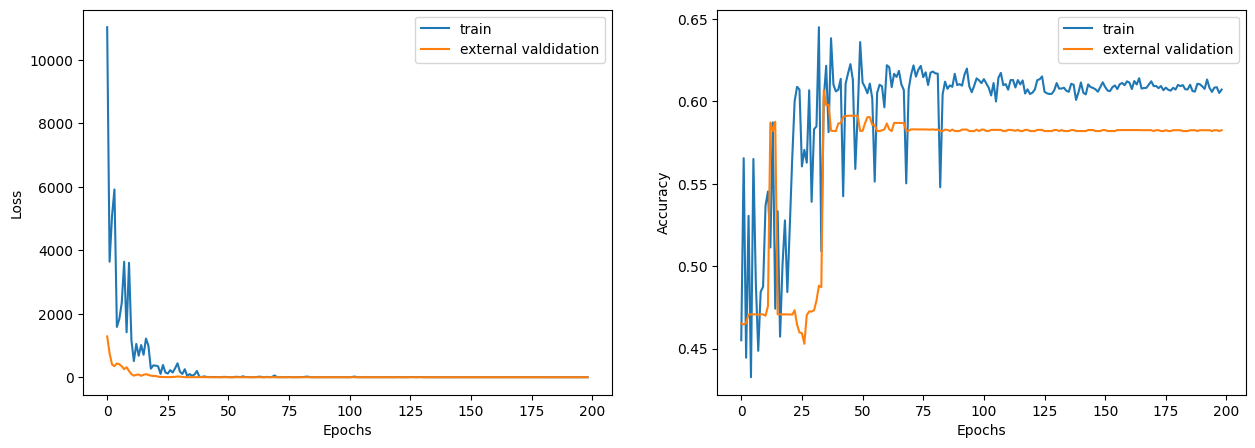

In [16]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)

os.mkdir("/mnt/degreePkts")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external valdidation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()
plt.savefig("/mnt/degreePkts/degreePkts_adam_0.01.png")

In [17]:
%%capture cap 

# PREDICCION #--no-stderr
for _ in range(loader_test_Tati.steps_per_epoch):
    inputs,target = loader_test_Tati.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=2) 
    print(result)

# confusion_matrix = [[TP, FN],
#                     [FP, TN]]
TP = result[0,0].numpy()
FN = result[0,1].numpy()
FP = result[1,0].numpy()
TN = result[1,1].numpy()

accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
especificity = TN/(TN+FP)
f1 = (2*precision*recall)/(precision+recall)

print("\n")
print("accuracy (exactitud) = ", accuracy) # cantidad de predicciones positivas que fueron correctas
print("precision = ", precision) # proporcion de casos positivos detectados
print("recall = ", recall) # casos positivos que fueron correctamente identificadas por el algoritmo
print("especificity = ", especificity) # casos negativos que el algoritmo ha clasificado correctamente
print("f1 = ", f1)

In [18]:
with open('/mnt/degreePkts/degreePkts_adam_0.01.txt', 'w') as f:
    f.write(cap.stdout)
    
cap()

tf.Tensor(
[[191767      4]
 [189550    129]], shape=(2, 2), dtype=int32)


accuracy (exactitud) =  0.5030698649888583
precision =  0.5029070301088071
recall =  0.9999791417889045
especificity =  0.0006800963733465486
f1 =  0.669241024066112


### PRUEBA 2: optimizer = Adam; learning_rate = 0.001

In [8]:
model = GCN(n_labels=dataset.n_labels)

optimizer = Adam(learning_rate=0.001)
#loss_fn = CategoricalCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [9]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 9639.45703 - Acc: 0.47946 - Val loss: 2764.78592 - Val acc: 0.58197
Ep. 1 - Loss: 7245.89258 - Acc: 0.47933 - Val loss: 2624.73742 - Val acc: 0.58197
Ep. 2 - Loss: 10838.20410 - Acc: 0.63632 - Val loss: 2495.41845 - Val acc: 0.58198
Ep. 3 - Loss: 12174.73535 - Acc: 0.55478 - Val loss: 2365.22034 - Val acc: 0.58198
Ep. 4 - Loss: 16430.60156 - Acc: 0.54029 - Val loss: 2219.31308 - Val acc: 0.58198
Ep. 5 - Loss: 11680.20605 - Acc: 0.57578 - Val loss: 2086.92084 - Val acc: 0.58197
Ep. 6 - Loss: 7517.57910 - Acc: 0.52783 - Val loss: 1996.09011 - Val acc: 0.58199
Ep. 7 - Loss: 8863.47168 - Acc: 0.62462 - Val loss: 1921.74363 - Val acc: 0.58199
Ep. 8 - Loss: 8035.76953 - Acc: 0.62400 - Val loss: 1853.78682 - Val acc: 0.58195
Ep. 9 - Loss: 6595.14795 - Acc: 0.55202 - Val loss: 1790.69059 - Val acc: 0.58195
Ep. 10 - Loss: 12972.28809 - Acc: 0.54095 - Val loss: 1702.95410 - Val acc: 0.58194
Ep. 11 - Loss: 9977.50293 - Acc: 0.62874 - Val loss: 1607.17309 - Val acc: 0.58195
Ep. 12 - 

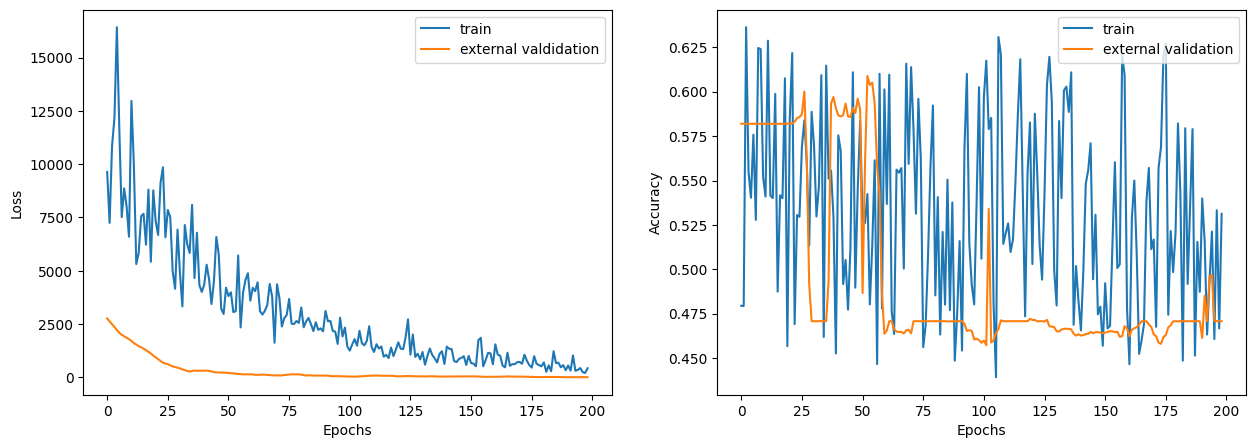

In [10]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external valdidation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()
plt.savefig("/mnt/degreePkts/degreePkts_adam_0.001.png")

In [11]:
%%capture cap

# PREDICCION
for _ in range(loader_test_Tati.steps_per_epoch):
    inputs,target = loader_test_Tati.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=2) 
    print(result)

# confusion_matrix = [[TP, FN],
#                     [FP, TN]]
TP = result[0,0].numpy()
FN = result[0,1].numpy()
FP = result[1,0].numpy()
TN = result[1,1].numpy()

accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
especificity = TN/(TN+FP)
f1 = (2*precision*recall)/(precision+recall)

print("\n")
print("accuracy (exactitud) = ", accuracy) # cantidad de predicciones positivas que fueron correctas
print("precision = ", precision) # proporcion de casos positivos detectados
print("recall = ", recall) # casos positivos que fueron correctamente identificadas por el algoritmo
print("especificity = ", especificity) # casos negativos que el algoritmo ha clasificado correctamente
print("f1 = ", f1)

In [12]:
with open('/mnt/degreePkts/degreePkts_adam_0.001.txt', 'w') as f:
    f.write(cap.stdout)

cap()

tf.Tensor(
[[ 19987 171784]
 [   663 189016]], shape=(2, 2), dtype=int32)


accuracy (exactitud) =  0.5479171582120854
precision =  0.9678934624697336
recall =  0.1042232662915665
especificity =  0.9965046209648933
f1 =  0.18818290093728965


### PRUEBA 3: optimizer = rmsprop; learning_rate = 0.001

In [8]:
model = GCN(n_labels=dataset.n_labels)

optimizer = RMSprop(learning_rate=0.001)
#loss_fn = CategoricalCrossentropy()
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [9]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
resultsTrain = []
resultsVal = []

# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, acc = train_step(*batch)

    # Append the loss and accuracy to the results list
    results.append((loss, acc))

    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate(loader_val) # CAMBIO A loader_val
        resultsVal.append(results_te)
        resultsTrain.append(np.mean(results,0))

        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.5f} - Acc: {:.5f} - Val loss: {:.5f} - Val acc: {:.5f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )

        # Reset the results list to start collecting results for the next epoch
        results = []


Ep. 0 - Loss: 5949.19678 - Acc: 0.50733 - Val loss: 95.15658 - Val acc: 0.60246
Ep. 1 - Loss: 4391.62988 - Acc: 0.56168 - Val loss: 75.81893 - Val acc: 0.60198
Ep. 2 - Loss: 3956.25171 - Acc: 0.44198 - Val loss: 60.37469 - Val acc: 0.52479
Ep. 3 - Loss: 3119.99341 - Acc: 0.59518 - Val loss: 58.11477 - Val acc: 0.58243
Ep. 4 - Loss: 4804.91553 - Acc: 0.56286 - Val loss: 55.99097 - Val acc: 0.46701
Ep. 5 - Loss: 3756.04980 - Acc: 0.50259 - Val loss: 65.75644 - Val acc: 0.46872
Ep. 6 - Loss: 4506.94385 - Acc: 0.53071 - Val loss: 118.39940 - Val acc: 0.47025
Ep. 7 - Loss: 5050.49805 - Acc: 0.47484 - Val loss: 132.63774 - Val acc: 0.47040
Ep. 8 - Loss: 4389.01562 - Acc: 0.58190 - Val loss: 152.24391 - Val acc: 0.47044
Ep. 9 - Loss: 3279.25952 - Acc: 0.49929 - Val loss: 139.02447 - Val acc: 0.47040
Ep. 10 - Loss: 4913.29248 - Acc: 0.49730 - Val loss: 115.18384 - Val acc: 0.47037
Ep. 11 - Loss: 3915.83789 - Acc: 0.55589 - Val loss: 146.35111 - Val acc: 0.47045
Ep. 12 - Loss: 4459.42285 - Acc:

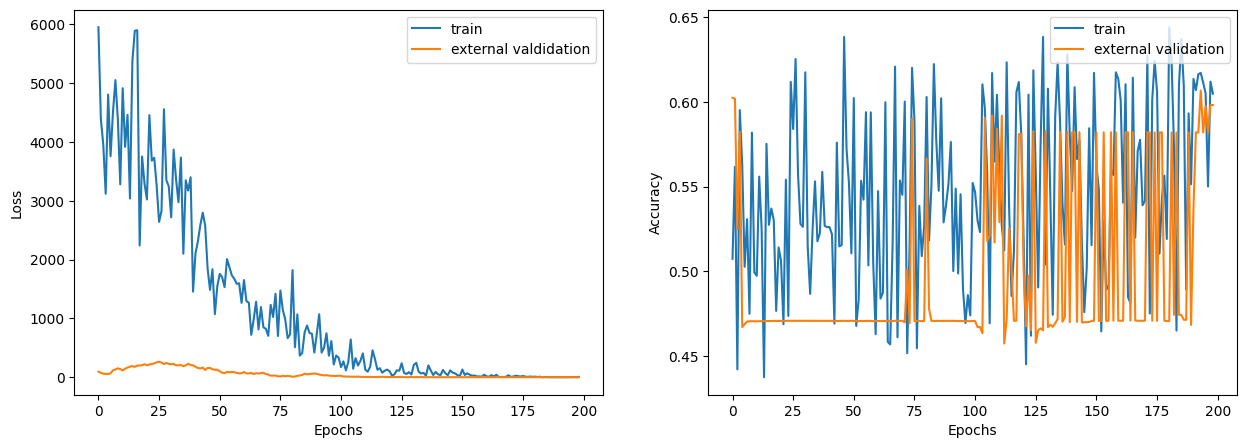

In [10]:
import matplotlib.pyplot as plt

resultsTrain = np.matrix(resultsTrain)
resultsVal = np.matrix(resultsVal)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,0])))
ax1.plot(np.squeeze(np.matrix.tolist(resultsVal[:,0])))
ax1.legend(["train", "external valdidation"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(np.squeeze(np.matrix.tolist(resultsTrain[:,1])))
ax2.plot(np.squeeze(np.matrix.tolist(resultsVal[:,1])))
ax2.legend(["train", "external validation"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()
plt.savefig("/mnt/degreePkts/degreePkts_rmsprop_0.001.png")

In [11]:
%%capture cap

# PREDICCION
for _ in range(loader_test_Tati.steps_per_epoch):
    inputs,target = loader_test_Tati.__next__()
    y_prediction = model(inputs, training=False)
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test=np.argmax(target, axis=1)
    #Create confusion matrix and normalizes it over predicted (columns)
    result = tf.math.confusion_matrix(y_test, y_prediction, num_classes=2) 
    print(result)

# confusion_matrix = [[TP, FN],
#                     [FP, TN]]
TP = result[0,0].numpy()
FN = result[0,1].numpy()
FP = result[1,0].numpy()
TN = result[1,1].numpy()

accuracy = (TP+TN)/(TP+FP+FN+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
especificity = TN/(TN+FP)
f1 = (2*precision*recall)/(precision+recall)

print("\n")
print("accuracy (exactitud) = ", accuracy) # cantidad de predicciones positivas que fueron correctas
print("precision = ", precision) # proporcion de casos positivos detectados
print("recall = ", recall) # casos positivos que fueron correctamente identificadas por el algoritmo
print("especificity = ", especificity) # casos negativos que el algoritmo ha clasificado correctamente
print("f1 = ", f1)

In [12]:
with open('/mnt/degreePkts/degreePkts_rmsprop_0.001.txt', 'w') as f:
    f.write(cap.stdout)

cap()

tf.Tensor(
[[191046    725]
 [182814   6865]], shape=(2, 2), dtype=int32)


accuracy (exactitud) =  0.5188386420238563
precision =  0.5110094687851068
recall =  0.996219449238936
especificity =  0.03619272560483765
f1 =  0.6755146022760422
